In [65]:
import os
import h5py
import torch
import cv2
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def sort_key_by_value(src_dict):
    sorted_items = sorted(src_dict, key=lambda item: src_dict[item], reverse=True)
    return sorted_items

target_patch_ids = [25, 28, 31, 34, 37, 40, 
                        43, 46, 97, 100, 103, 106,
                        109, 112, 115, 118, 169, 172,
                        175, 178, 181, 184, 187, 190,
                        241, 244, 247, 250, 253, 256,
                        259, 262, 313, 316, 319, 322,
                        325, 328, 331, 334, 385, 388,
                        391, 394, 397, 400, 403, 406,
                        457, 460, 463, 466, 469, 472,
                        475, 478, 529, 532, 535, 538,
                        541, 544, 547, 550]
ll = len(target_patch_ids)
res_root = '/DATA2/yangdingchen/LMMs-Eval-Lite/vqav2_val/results/'
fr_name = '250105-214941/llavaNext-vqav2-analysis-token-reduce-attn_prob_jsd_result.jsonl'  # TODO
placeholder = "<|placeholder|>"
fr_vit_cls_sim = f'250118-142510/llavaNext_vqav2_zeroshot_analysis_token_reduc_pre_exp_vit_cls-{placeholder}.txt'
k_local = 1  # TODO
k_global = 16  # TODO

fr = (json.loads(q) for q in open(os.path.join(res_root, fr_name), 'r', encoding='utf-8'))

sum_attn_score_dict = {}
for target_patch_id in target_patch_ids:
    target_patch_id = str(target_patch_id)
    assert target_patch_id not in sum_attn_score_dict
    sum_attn_score_dict.update({target_patch_id:0})

sum_attn_score_list = []
prob_list = []
local_jsd_list = []
global_jsd_list = []
cls_sim_list = []

for datasample in tqdm(fr):
    attn_scores = datasample["attn_scores"]
    selected_attn_layers = datasample["selected_attn_layers"]
    top_1_probs = datasample["top_1_probs"]
    local_jsds = datasample["local_jsds"]
    global_jsds = datasample["global_jsds"]
    sample_id = datasample["sample_id"]
    
    # read attn scores
    for selected_attn_layer in selected_attn_layers:
        selected_attn_layer = str(selected_attn_layer)
        attn_scores_this_layer = attn_scores[selected_attn_layer]
        # print(attn_scores_this_layer)
        for target_patch_id in target_patch_ids:
            target_patch_id = str(target_patch_id)
            sum_attn_score_dict[target_patch_id] = sum_attn_score_dict[target_patch_id] \
                + attn_scores_this_layer[target_patch_id]
    
    # read vit-cls sim
    vit_cls_sim_file = res_root + fr_vit_cls_sim.replace(placeholder, sample_id)
    lines = open(vit_cls_sim_file, 'r', encoding='utf-8').readlines()
    vit_cls_dict = {}
    for line in lines:
        datas = json.loads(line)
        for _, v in datas.items():
            if int(list(v.keys())[0]) in target_patch_ids:
                vit_cls_dict.update(v)
            
    # sort according to attn score
    sorted_patch_ids = sort_key_by_value(sum_attn_score_dict)  # TODO
    # sorted_patch_ids = sort_key_by_value(vit_cls_dict)  # TODO
    
    # read other metrics
    sort_sum_attn_score_list = [sum_attn_score_dict[qq] for qq in sorted_patch_ids]
    sort_prob_list = [top_1_probs[qq] for qq in sorted_patch_ids]
    sort_local_jsd_list = [local_jsds[qq] for qq in sorted_patch_ids]
    sort_global_jsd_list = [global_jsds[qq] for qq in sorted_patch_ids]
    sort_vit_cls_sim_list = [vit_cls_dict[qq] for qq in sorted_patch_ids]
    
    sort_sum_attn_score_tensor = torch.tensor([sort_sum_attn_score_list])
    sort_prob_tensor = torch.tensor([sort_prob_list])
    sort_local_jsd_tensor = torch.tensor([sort_local_jsd_list])
    sort_global_jsd_tensor = torch.tensor([sort_global_jsd_list])
    sort_vit_cls_sim_tensor = torch.tensor([sort_vit_cls_sim_list])
    
    sum_attn_score_list.append(sort_sum_attn_score_tensor)
    prob_list.append(sort_prob_tensor)
    local_jsd_list.append(sort_local_jsd_tensor)
    global_jsd_list.append(sort_global_jsd_tensor)
    cls_sim_list.append(sort_vit_cls_sim_tensor)

sum_attn_scores = torch.cat(sum_attn_score_list, dim=0).mean(dim=0).tolist()
probs = torch.cat(prob_list, dim=0).mean(dim=0).tolist()

local_jsds = torch.cat(local_jsd_list, dim=0).mean(dim=0).tolist()
global_jsds = torch.cat(global_jsd_list, dim=0).mean(dim=0).tolist()
jsds = [k_local * a + k_global * b for a, b in zip(local_jsds, global_jsds)]

# cls_sims = torch.cat(cls_sim_list, dim=0).max(dim=0)[0].tolist()
cls_sims = torch.cat(cls_sim_list, dim=0).mean(dim=0).tolist()
# print(len(cls_sims))

100it [00:00, 623.68it/s]


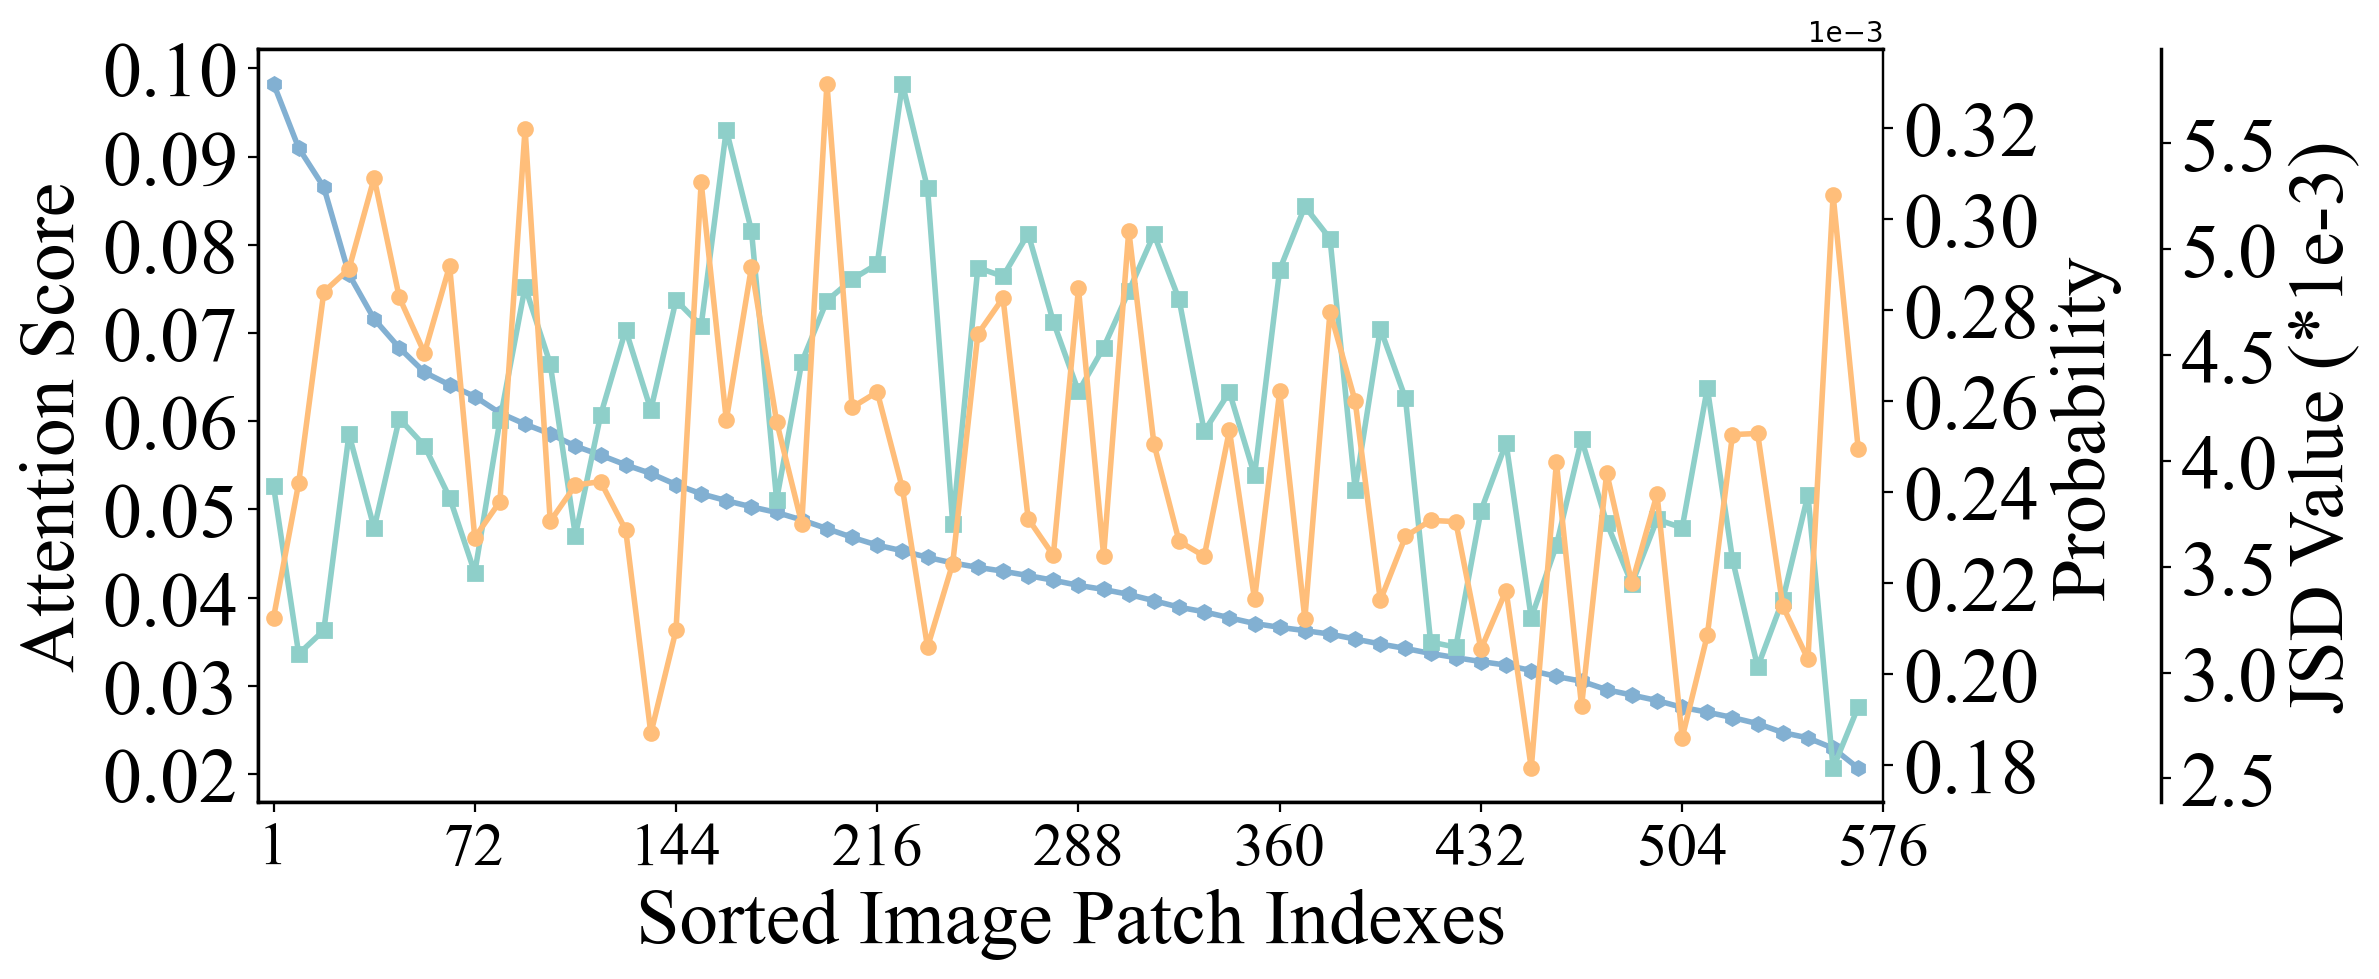

In [66]:
import matplotlib.font_manager as font_manager

font_s = 24
markersize = 5
# font_n = "Times New Roman"
csfont = font_manager.FontProperties(family='Times New Roman',
                                   style='normal', size=font_s-4)
# font_n = "Arial"
# font_n = "Helvetica"
font_n = 'Times New Roman'
line_s = 2.0
border_s = 1.25
bar_width = 0.25
margins = 0.01
# bar_distance = 0.5

fig, ax1 = plt.subplots(figsize=(12, 5), dpi=200)
# plt.margins(x=0.0)
# plt.subplots_adjust(left=-0.8, right=1.6)

ax1.plot(sum_attn_scores, 
         alpha=1.0,
         label="Sum of attention scores across layers", 
         linewidth=line_s, color="#82B0D2", linestyle='-', marker='h', markersize=markersize)
ax1.margins(x=margins)
ax1.set_xlabel('Sorted Image Patch Indexes', fontsize=font_s+4, fontname='Times New Roman')
ax1.set_ylabel("Attention Score", fontsize=font_s+4, fontname='Times New Roman')
ax1.tick_params(axis='y')
x1_label = ax1.get_yticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
[x1_label_temp.set_fontsize(font_s+4) for x1_label_temp in x1_label]


ax2 = ax1.twinx()
ax2.plot(probs, 
         alpha=1.0,
         label="Top-1 candidates' probabilities", 
         linewidth=line_s, color="#8ECFC9", linestyle='-', marker='s', markersize=markersize)

# ax2.plot(cls_sims, 
#          alpha=1.0,
#          label="ViT-[cls] Cosine Similarities", 
#          linewidth=line_s, color="#4EAF39", linestyle='-', marker='s', markersize=markersize)

ax2.margins(x=margins)
ax2.set_ylabel('Probability', fontsize=font_s+4, fontname='Times New Roman')
ax2.tick_params(axis='y')
x2_label = ax2.get_yticklabels() 
[x2_label_temp.set_fontname('Times New Roman') for x2_label_temp in x2_label]
[x2_label_temp.set_fontsize(font_s+4) for x2_label_temp in x2_label]


ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 100))
ax3.plot(jsds, 
         alpha=1.0,
         label="JSD values", 
         linewidth=line_s, color="#FFBE7A", linestyle='-', marker='o', markersize=markersize)
ax3.ticklabel_format(style='sci', scilimits=(-4,-3))
ax3.margins(x=margins)
ax3.set_ylabel('JSD Value (*1e-3)', fontsize=font_s+4, fontname='Times New Roman')
ax3.tick_params(axis='y')
x3_label = ax3.get_yticklabels() 
[x3_label_temp.set_fontname('Times New Roman') for x3_label_temp in x3_label]
[x3_label_temp.set_fontsize(font_s+4) for x3_label_temp in x3_label]


ax = plt.gca()
ax.spines["top"].set_linewidth(border_s)
ax.spines["bottom"].set_linewidth(border_s)
ax.spines["left"].set_linewidth(border_s)
ax.spines["right"].set_linewidth(border_s)

x_tic = [1,72,144,216,288,360,432,504,576]
# ax1.set_xticks(list(range(64)), target_patch_ids, rotation=45, fontsize=font_s-5, fontname=font_n)
ax1.set_xticks([0,8,16,24,32,40,48,56,64])
ax1.set_xticklabels(x_tic,fontsize=font_s-2, fontname=font_n)
# labels = ax1.set_xticklabels(, rotation=45,fontsize=20,fontname='Times New Roman')
# 添加图表标题
# plt.title('商品评分、价格与销量折线图')

# legend = fig.legend(bbox_to_anchor=(-0.18, 0.02, 1.2, .102), loc='upper left',ncol=3,
#            mode="expand", borderaxespad=-13.0, borderpad=0.6, columnspacing=4., prop=csfont)  # set font size by prop

# fig.legend(bbox_to_anchor=(0.84, 0.86, 0, 0.1), loc='upper right', prop=csfont)

# 显示图表
plt.tight_layout()  # 调整布局避免标签重叠
plt.show()

100it [00:00, 627.41it/s]


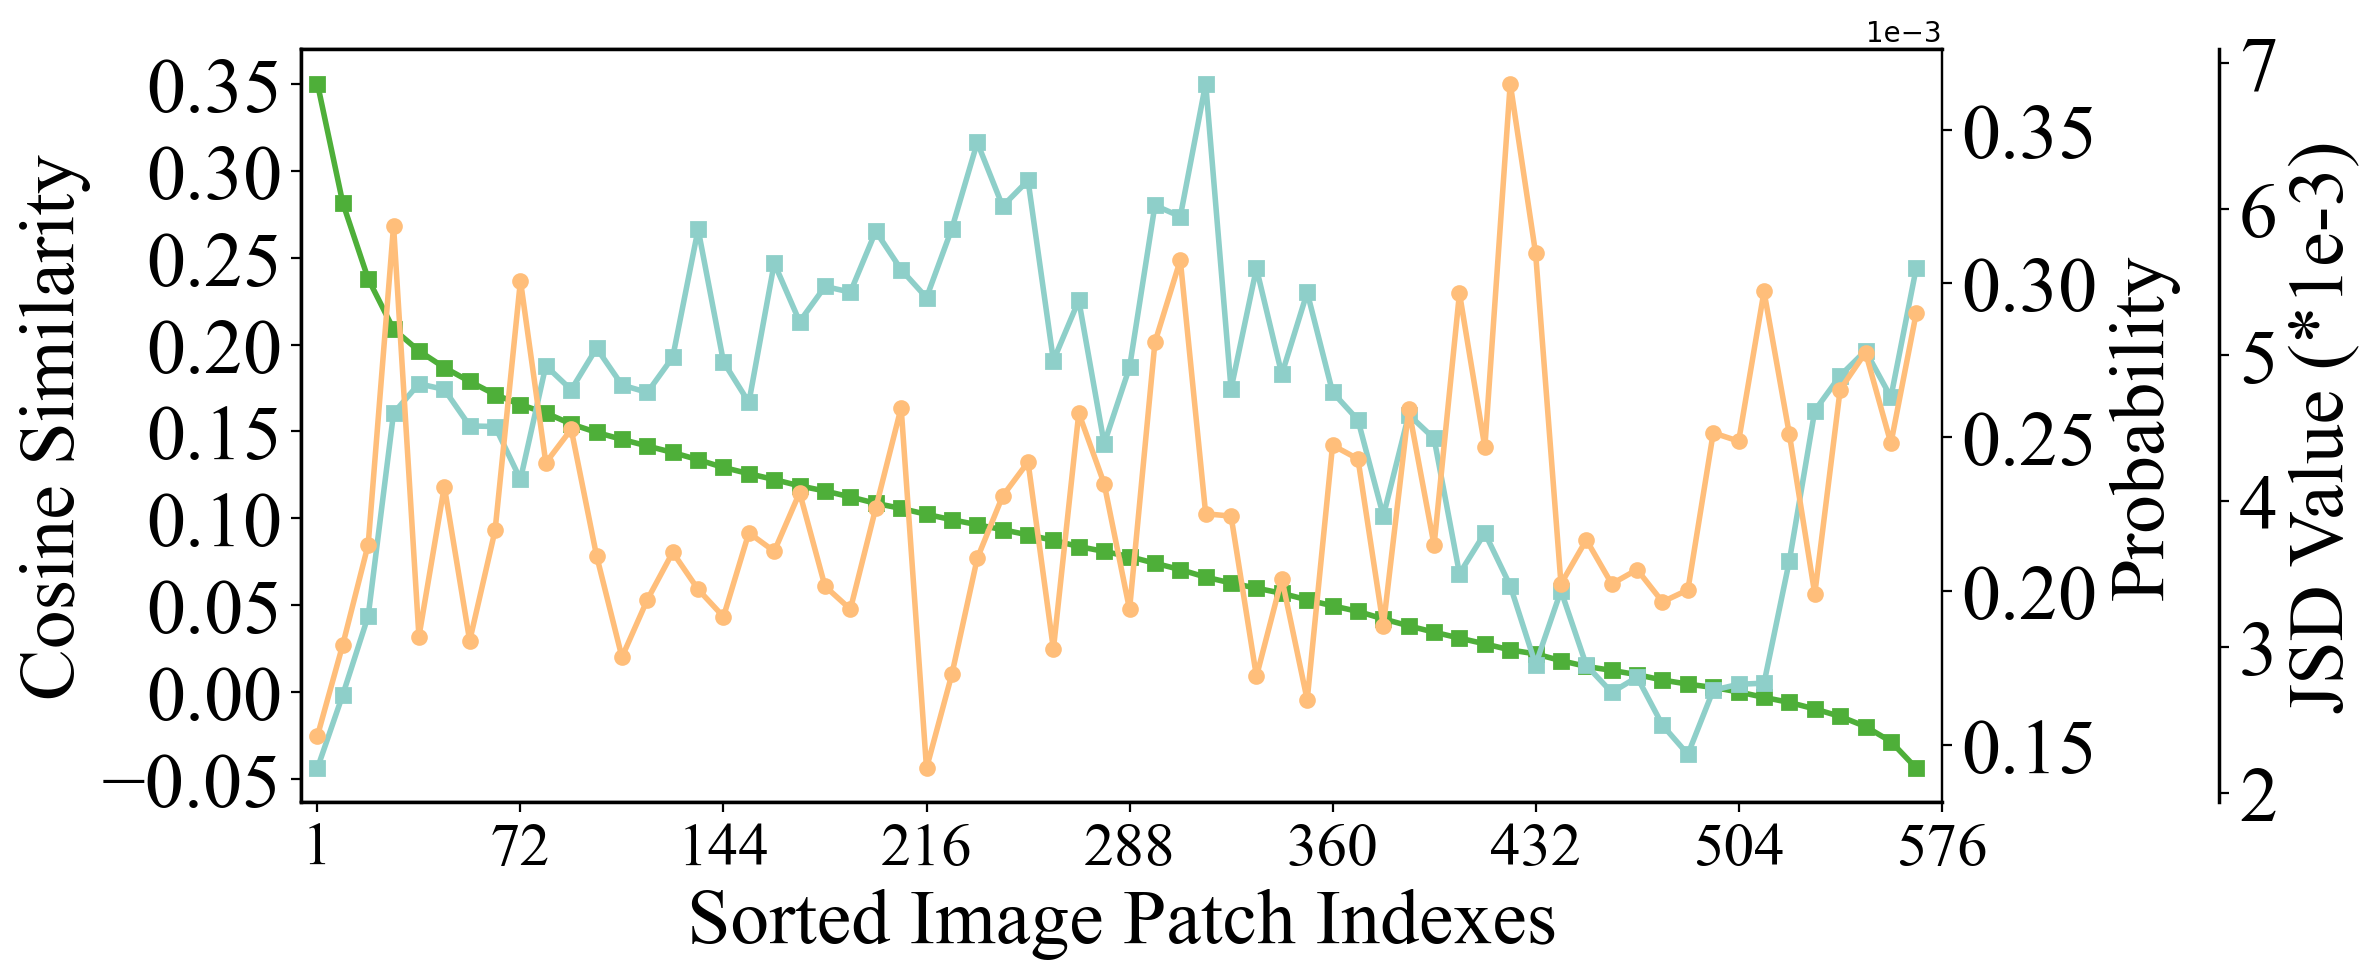

In [67]:
import os
import h5py
import torch
import cv2
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager

def sort_key_by_value(src_dict):
    sorted_items = sorted(src_dict, key=lambda item: src_dict[item], reverse=True)
    return sorted_items

target_patch_ids = [25, 28, 31, 34, 37, 40, 
                        43, 46, 97, 100, 103, 106,
                        109, 112, 115, 118, 169, 172,
                        175, 178, 181, 184, 187, 190,
                        241, 244, 247, 250, 253, 256,
                        259, 262, 313, 316, 319, 322,
                        325, 328, 331, 334, 385, 388,
                        391, 394, 397, 400, 403, 406,
                        457, 460, 463, 466, 469, 472,
                        475, 478, 529, 532, 535, 538,
                        541, 544, 547, 550]
ll = len(target_patch_ids)
res_root = '/DATA2/yangdingchen/LMMs-Eval-Lite/vqav2_val/results/'
fr_name = '250105-214941/llavaNext-vqav2-analysis-token-reduce-attn_prob_jsd_result.jsonl'  # TODO
placeholder = "<|placeholder|>"
fr_vit_cls_sim = f'250118-142510/llavaNext_vqav2_zeroshot_analysis_token_reduc_pre_exp_vit_cls-{placeholder}.txt'
k_local = 1  # TODO
k_global = 16  # TODO

fr = (json.loads(q) for q in open(os.path.join(res_root, fr_name), 'r', encoding='utf-8'))

sum_attn_score_dict = {}
for target_patch_id in target_patch_ids:
    target_patch_id = str(target_patch_id)
    assert target_patch_id not in sum_attn_score_dict
    sum_attn_score_dict.update({target_patch_id:0})

sum_attn_score_list = []
prob_list = []
local_jsd_list = []
global_jsd_list = []
cls_sim_list = []

for datasample in tqdm(fr):
    attn_scores = datasample["attn_scores"]
    selected_attn_layers = datasample["selected_attn_layers"]
    top_1_probs = datasample["top_1_probs"]
    local_jsds = datasample["local_jsds"]
    global_jsds = datasample["global_jsds"]
    sample_id = datasample["sample_id"]
    
    # read attn scores
    for selected_attn_layer in selected_attn_layers:
        selected_attn_layer = str(selected_attn_layer)
        attn_scores_this_layer = attn_scores[selected_attn_layer]
        # print(attn_scores_this_layer)
        for target_patch_id in target_patch_ids:
            target_patch_id = str(target_patch_id)
            sum_attn_score_dict[target_patch_id] = sum_attn_score_dict[target_patch_id] \
                + attn_scores_this_layer[target_patch_id]
    
    # read vit-cls sim
    vit_cls_sim_file = res_root + fr_vit_cls_sim.replace(placeholder, sample_id)
    lines = open(vit_cls_sim_file, 'r', encoding='utf-8').readlines()
    vit_cls_dict = {}
    for line in lines:
        datas = json.loads(line)
        for _, v in datas.items():
            if int(list(v.keys())[0]) in target_patch_ids:
                vit_cls_dict.update(v)
            
    # sort according to attn score
    # sorted_patch_ids = sort_key_by_value(sum_attn_score_dict)  # TODO
    sorted_patch_ids = sort_key_by_value(vit_cls_dict)  # TODO
    
    # read other metrics
    sort_sum_attn_score_list = [sum_attn_score_dict[qq] for qq in sorted_patch_ids]
    sort_prob_list = [top_1_probs[qq] for qq in sorted_patch_ids]
    sort_local_jsd_list = [local_jsds[qq] for qq in sorted_patch_ids]
    sort_global_jsd_list = [global_jsds[qq] for qq in sorted_patch_ids]
    sort_vit_cls_sim_list = [vit_cls_dict[qq] for qq in sorted_patch_ids]
    
    sort_sum_attn_score_tensor = torch.tensor([sort_sum_attn_score_list])
    sort_prob_tensor = torch.tensor([sort_prob_list])
    sort_local_jsd_tensor = torch.tensor([sort_local_jsd_list])
    sort_global_jsd_tensor = torch.tensor([sort_global_jsd_list])
    sort_vit_cls_sim_tensor = torch.tensor([sort_vit_cls_sim_list])
    
    sum_attn_score_list.append(sort_sum_attn_score_tensor)
    prob_list.append(sort_prob_tensor)
    local_jsd_list.append(sort_local_jsd_tensor)
    global_jsd_list.append(sort_global_jsd_tensor)
    cls_sim_list.append(sort_vit_cls_sim_tensor)

sum_attn_scores = torch.cat(sum_attn_score_list, dim=0).mean(dim=0).tolist()
probs = torch.cat(prob_list, dim=0).mean(dim=0).tolist()

local_jsds = torch.cat(local_jsd_list, dim=0).mean(dim=0).tolist()
global_jsds = torch.cat(global_jsd_list, dim=0).mean(dim=0).tolist()
jsds = [k_local * a + k_global * b for a, b in zip(local_jsds, global_jsds)]

# cls_sims = torch.cat(cls_sim_list, dim=0).max(dim=0)[0].tolist()
cls_sims = torch.cat(cls_sim_list, dim=0).mean(dim=0).tolist()
# print(len(cls_sims))

font_s = 24
markersize = 5
# font_n = "Times New Roman"
csfont = font_manager.FontProperties(family='Times New Roman',
                                   style='normal', size=font_s-4)
# font_n = "Arial"
# font_n = "Helvetica"
font_n = 'Times New Roman'
line_s = 2.0
border_s = 1.25
bar_width = 0.25
margins = 0.01
# bar_distance = 0.5

fig, ax1 = plt.subplots(figsize=(12, 5), dpi=200)
# plt.margins(x=0.0)
# plt.subplots_adjust(left=-0.8, right=1.6)

ax1.plot(cls_sims, 
         alpha=1.0,
         label="ViT-[cls] Cosine Similarities", 
         linewidth=line_s, color="#4EAF39", linestyle='-', marker='s', markersize=markersize)
ax1.margins(x=margins)
ax1.set_xlabel('Sorted Image Patch Indexes', fontsize=font_s+4, fontname='Times New Roman')
ax1.set_ylabel("Cosine Similarity", fontsize=font_s+4, fontname='Times New Roman')
ax1.tick_params(axis='y')
x1_label = ax1.get_yticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
[x1_label_temp.set_fontsize(font_s+4) for x1_label_temp in x1_label]


ax2 = ax1.twinx()
ax2.plot(probs, 
         alpha=1.0,
         label="Top-1 candidates' probabilities", 
         linewidth=line_s, color="#8ECFC9", linestyle='-', marker='s', markersize=markersize)

ax2.margins(x=margins)
ax2.set_ylabel('Probability', fontsize=font_s+4, fontname='Times New Roman')
ax2.tick_params(axis='y')
x2_label = ax2.get_yticklabels() 
[x2_label_temp.set_fontname('Times New Roman') for x2_label_temp in x2_label]
[x2_label_temp.set_fontsize(font_s+4) for x2_label_temp in x2_label]


ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 100))
ax3.plot(jsds, 
         alpha=1.0,
         label="JSD values", 
         linewidth=line_s, color="#FFBE7A", linestyle='-', marker='o', markersize=markersize)
ax3.ticklabel_format(style='sci', scilimits=(-4,-3))
ax3.margins(x=margins)
ax3.set_ylabel('JSD Value (*1e-3)', fontsize=font_s+4, fontname='Times New Roman')
ax3.tick_params(axis='y')
x3_label = ax3.get_yticklabels() 
[x3_label_temp.set_fontname('Times New Roman') for x3_label_temp in x3_label]
[x3_label_temp.set_fontsize(font_s+4) for x3_label_temp in x3_label]


ax = plt.gca()
ax.spines["top"].set_linewidth(border_s)
ax.spines["bottom"].set_linewidth(border_s)
ax.spines["left"].set_linewidth(border_s)
ax.spines["right"].set_linewidth(border_s)

x_tic = [1,72,144,216,288,360,432,504,576]
# ax1.set_xticks(list(range(64)), target_patch_ids, rotation=45, fontsize=font_s-5, fontname=font_n)
ax1.set_xticks([0,8,16,24,32,40,48,56,64])
ax1.set_xticklabels(x_tic,fontsize=font_s-2, fontname=font_n)
# labels = ax1.set_xticklabels(, rotation=45,fontsize=20,fontname='Times New Roman')
# 添加图表标题
# plt.title('商品评分、价格与销量折线图')

# legend = fig.legend(bbox_to_anchor=(-0.18, 0.02, 1.2, .102), loc='upper left',ncol=3,
#            mode="expand", borderaxespad=-13.0, borderpad=0.6, columnspacing=4., prop=csfont)  # set font size by prop

# fig.legend(bbox_to_anchor=(0.84, 0.86, 0, 0.1), loc='upper right', prop=csfont)

# 显示图表
plt.tight_layout()  # 调整布局避免标签重叠
plt.show()